# fig2B_C

Code to make figures for the looming comparison figure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle
import seaborn as sns

import utils

import matplotlib
# Set some global plotting styles
matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10

%matplotlib notebook
%load_ext autoreload
%autoreload

/home/spoonsso/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# Set some variables
da = 0.05 
dw = 0.3
dp = 0.1
ddisp = da+dw+dp
dispcm = 2
dispres=2000

# Figure 2a -- Looming context

# Figure 2b -- Graph/quantification of looming implications

In [3]:
# Get a visual angle trajectory for all |R/V| values from Dunn et al.
t = 10 #seconds
rad = np.zeros((5,t*1000))
th = np.zeros((5,t*1000))
rv = [0.255, 0.490, 0.730, 0.980, 1.450]
for i in range(rad.shape[0]):
    rad[i,:], th[i,:] = utils.genRadFromRV(np.sqrt(ddisp**2+1), rv[i], t)

/mnt/c/Users/dunnt/Dropbox/snell/snell_tool/figures/utils.py:273: RuntimeWarning: divide by zero encountered in true_divide
  theta = 2*np.arctan(-RV/absRadt);


Workflow for this plot:
- Get absolute radius over time for each R/V, given the set distance to the screen (remember that this is independent of the dSc/h ratio for Snells's
- Draw circle in pixel space using these radii
- Get border of drawn circle
- Get projection onto sphere of border pixels
- Sort projected pixels
- Approximate solid angle using a sinusoidal projection

In [4]:
# To regenerate solid angle quantities, set to True (note: this will take a long tim)
regenerate = False

In [5]:
if regenerate:
    per = 10
    sAng = np.zeros((5,rad.shape[1]//per,))
    for j in [0,4]:
        for i in range(0,sAng.shape[1]):
            if i % 100 == 0:
                print(i)
            im = np.zeros((dispres*2+1,dispres+1),dtype='bool')
            utils.drawCirc(im,r=round(rad[j,i*per]*dispres/dispcm).astype('int32'),h=round(1*dispres/dispcm),k=2000)
            border = utils.get_border(im)
            xxx, psi_, theta_ = utils.border_to_sphere(border,h = round(ddisp*dispres/dispcm),center=dispres)

            # Sort psi, theta
            mean_y = np.mean(border[0])
            mean_x = np.mean(border[1])
            diff_y = border[0]-mean_y
            diff_x = border[1]-mean_x
            a = np.argsort(np.arctan2(diff_y,diff_x))

            psi_ = psi_[a]
            theta_ = theta_[a]

            psi_[np.isnan(psi_)] = 0 # for pixels at (0,0,-h)

            sAng[j,i] = utils.get_solid_angle(psi_, theta_-np.pi/2)
            
    # Use the snell tool plastic interface to get "dz" to be used for distorting the looming stimulus
    display_stochastic = snell.snell(dispres = int(dispres/2), dispcm = dispcm*2, da = da, dw = dw, dp = dp,
                                    num_stochastic=1,stoch_range=0)
    display_stochastic.make_display()
    
    dz = np.zeros((4000,4000,2))
    dz_ = display_stochastic.display[:,:,:,0]
    dz[:-1,:-1] = dz_

    per = 10
    sAng_snell_p = np.zeros((5,rad.shape[1]//per,))
    for j in [0,4]:#range(sAng.shape[0]):
        for i in range(0,sAng_snell_p.shape[1]):
            if i % 100 == 0:
                print(i)
            im = np.zeros((dispres*2+1,dispres+1),dtype='bool')
            utils.drawCirc(im,r=round(rad[j,i*per]*dispres/dispcm).astype('int32'),h=round(1*dispres/dispcm),k=2000)

            im = np.concatenate((np.zeros_like(im),im),axis=1)
            im = utils.snell_distort(dz,im[:-1,:-2],dispres)

            border = utils.get_border(im[:,2000:])
            xxx, psi_, theta_ = utils.border_to_sphere(border,h = round(ddisp*dispres/dispcm),center=dispres)

            # Sort psi, theta
            mean_y = np.mean(border[0])
            mean_x = np.mean(border[1])
            diff_y = border[0]-mean_y
            diff_x = border[1]-mean_x
            a = np.argsort(np.arctan2(diff_y,diff_x))

            psi_ = psi_[a]
            theta_ = theta_[a]

            sAng_snell_p[j,i] = utils.get_solid_angle(psi_, theta_-np.pi/2)
            
    # Save these variables
    f = open('looming_variables_plastic_{}mm_dw.pickle'.format(dw*10),'wb')
    cPickle.dump(rad,f)
    cPickle.dump(th,f)
    cPickle.dump(sAng,f)
    cPickle.dump(sAng_snell_p,f)
    f.close()

In [6]:
# Load these variables
f = open('../../plastics/looming_variables_plastic_3mm_dw.pickle','rb')
rad = cPickle.load(f)
th = cPickle.load(f)
sAng = cPickle.load(f)
sAng_snell_p = cPickle.load(f)
f.close()

In [7]:
# Get a visual angle trajectory for all |R/V| values from Temizer et al. (just the slowest approach speed)
t = 10 #seconds
tem_ddisp = 1
rad_tem = np.zeros((1,t*1000))
th_tem = np.zeros((1,t*1000))
rv = [0.150]
for i in range(rad_tem.shape[0]):
    rad_tem[i,:], th_tem[i,:] = utils.genRadFromRV(tem_ddisp, rv[i], t)
    
th_tem = th_tem[0,::10]
th_fast = th[0,::10]
th_slow = th[4,::10]

In [8]:
temrad = 2*np.pi*(1-np.cos(th_tem/2))

# For the snell corrected temizer solid angle
the = np.linspace(0,50,10000)
the_tild = utils.temizer(the)

the_tild_plastic = utils.temizer_plastic(the)

# The Snell-adjusted critical visual angle
th_tem_snell = np.zeros_like(th_tem)
th_tem_snell_plastic = np.zeros_like(th_tem)
for i in range(len(th_tem_snell)):
    # The find_nearest call goes backwards -- e.g. given that thea of 15 degrees might result in, say theta_prime
    # of 20 degrees, we want to find when the un-corrected angle is 20 degrees, and then look up the corresponding
    # smaller angle (theta) at that index
    adj = the[utils.find_nearest(the_tild,th_tem[i]/2)]
    temrad_adj = 2*np.pi*(1-np.cos(adj*np.pi/180))
    th_tem_snell[i] = temrad_adj
    
    adj_plastic = the[utils.find_nearest(the_tild_plastic,th_tem[i]/2)]
    temrad_adj_plastic = 2*np.pi*(1-np.cos(adj_plastic*np.pi/180))
    th_tem_snell_plastic[i] = temrad_adj_plastic


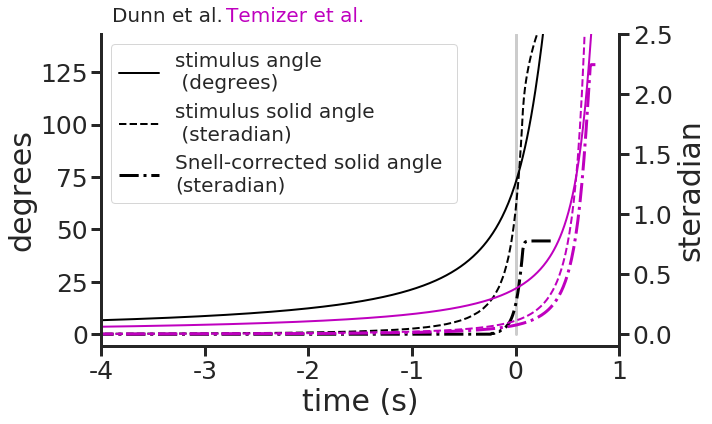

In [9]:
# Align traces to published critical angles
dunn_start = 165
tem_start = 122

plt.figure(figsize=(10,6))
sns.set_style('ticks',{"xtick.major.size": "10", "ytick.major.size": "10",'axes.linewidth': 3})

sns.set_palette(sns.color_palette("tab10"))
plt.plot([800, 800],[0,2.5],'k',alpha=0.2,linewidth=3)

plt.plot(th_fast[dunn_start:],'k',label='stimulus angle \n (degrees)',linewidth=2)
plt.plot(sAng[0,dunn_start:],'--k',label='stimulus solid angle \n (steradian)',linewidth=2)
plt.plot(sAng_snell_p[0,dunn_start:],'-.k', label='Snell-corrected solid angle \n(steradian)',linewidth=3)
plt.plot(th_tem[tem_start:], 'm',linewidth=2)
plt.plot(temrad[tem_start:], '--m',linewidth=2)
plt.plot(th_tem_snell_plastic[tem_start:], '-.m',linewidth=3)

plt.ylabel('degrees',size=30)
plt.xlabel('time (s)',size=30)
plt.xticks([0, 200, 400, 500, 600, 700, 800, 900],['0','2','-4','-3','-2','-1','0', '1'])
plt.xlim([400,900])
plt.yticks(np.array([0, 25, 50, 75, 100, 125])*np.pi/180,[0, 25, 50, 75, 100, 125])
plt.ylim([-0.1,2.5])
plt.legend(fontsize=20)

ax = plt.gca()
ax.tick_params(width=3,labelsize=25)
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.tick_params(width=3,labelsize=25)
ax2.set_ylabel('steradian',size=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.text(410,2.6,'Dunn et al.',fontsize=20)
plt.text(520,2.6,'Temizer et al.',color='m',fontsize=20)
plt.tight_layout()
plt.savefig('../../paper/elife_revision/fig2b.pdf')

# Figure 2c -- bar graphs to support fix

In [10]:
# Spherical cap formula -- temizer no snell
ang = 21.7/2
temrad = 2*np.pi*(1-np.cos(ang*np.pi/180))
ang_u = (21.7+2.5*1.96)/2
temrad_u = 2*np.pi*(1-np.cos(ang_u*np.pi/180))
ang_l = (21.7-2.5*1.96)/2
temrad_l = 2*np.pi*(1-np.cos(ang_l*np.pi/180))

In [11]:
# For the snell corrected temizer solid angle
the = np.linspace(0,20,1000)
the_tild_plastic = utils.temizer_plastic(the)

# The Snell-adjusted critical visual angle
adj = the[utils.find_nearest(the_tild_plastic*180/np.pi,21.7/2)]*2
temrad_adj = 2*np.pi*(1-np.cos(adj/2*np.pi/180))

# Get the 95% CI for the snell-adjusted size
adj_u = the[utils.find_nearest(the_tild_plastic*180/np.pi,(21.7+2.5*1.96)/2)]*2
temrad_adj_u = 2*np.pi*(1-np.cos(adj_u/2*np.pi/180))

adj_l = the[utils.find_nearest(the_tild_plastic*180/np.pi,(21.7-2.5*1.96)/2)]*2
temrad_adj_l = 2*np.pi*(1-np.cos(adj_l/2*np.pi/180))

In [12]:
frac = np.pi
frac2 = 2*np.pi

rad = np.array([0.38, 1.26])/frac
err_rad_dunn = 1.3*np.pi/180*1.96/frac
err_rad_tem = 2.5*np.pi/180*1.96/frac

ster = np.array([temrad, sAng[4,800]])/frac2 #sAng[4,800] corresponds to the time point when stim reaches crit visual angle
err_ster_tem = abs(np.array([temrad_l, temrad_u])-temrad)/frac2
err_ster_dunn = abs(np.array([sAng[4,int(np.round(utils.find_nearest(th[4,:]*180/np.pi,72.0 - 1.3*1.96)/10))],
                         sAng[4,int(np.round(utils.find_nearest(th[4,:]*180/np.pi,72.0 + 1.3*1.96)/10))]]) - sAng[4,800])/frac2

ster_snell = np.array([temrad_adj, sAng_snell_p[4,800]])/frac2
err_ster_snell_tem = abs(np.array([temrad_adj_l, temrad_adj_u])-temrad_adj)/frac2
err_ster_snell_dunn = np.array([sAng_snell_p[4,int(np.round(utils.find_nearest(th[4,:]*180/np.pi,72.0 - 1.3*1.96)/10))],
                         sAng_snell_p[4,int(np.round(utils.find_nearest(th[4,:]*180/np.pi,72.0 + 1.3*1.96)/10))]]) \
                            - sAng_snell_p[4,800]
err_ster_snell_dunn = abs(err_ster_snell_dunn)/frac2

## Do the plot

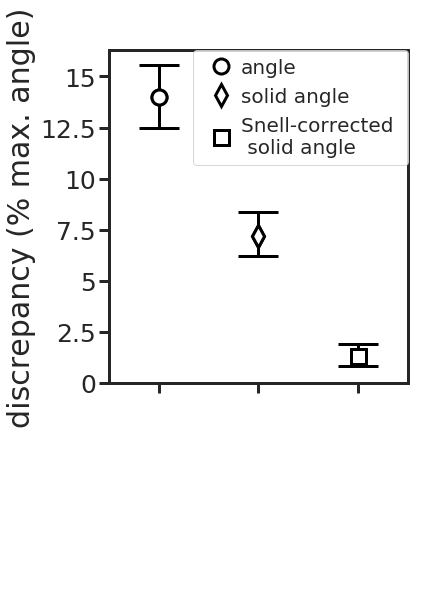

In [13]:
plt.figure(figsize=(6,8))

plt.errorbar(1,rad[1]-rad[0],np.sqrt(err_rad_tem**2+err_rad_dunn**2),color='k',
             linewidth=3,marker='o',markersize=15,markerfacecolor='white',markeredgewidth=3,capsize=20,)
plt.plot(1,rad[1]-rad[0],color='k',marker='o',markersize=15,markerfacecolor='white',
         markeredgewidth=3,linestyle='None',label='angle')

tot_err_ster = np.array([np.sqrt(err_ster_tem[0]**2 + err_ster_dunn[0]**2), np.sqrt(err_ster_tem[1]**2 + err_ster_dunn[1]**2)])
plt.errorbar(2,ster[1]-ster[0],tot_err_ster[:,np.newaxis],color='k',
             linewidth=3,marker='d',markersize=15,markerfacecolor='white',markeredgewidth=3,capsize=20)
plt.plot(2,ster[1]-ster[0],color='k',marker='d',markersize=15,markerfacecolor='white',
         markeredgewidth=3,linestyle='None',label='solid angle')

tot_err_snell = np.array([np.sqrt(err_ster_snell_tem[0]**2 + err_ster_snell_dunn[0]**2), 
                          np.sqrt(err_ster_snell_tem[1]**2 + err_ster_snell_dunn[1]**2)])

plt.errorbar(3,ster_snell[1]-ster_snell[0],tot_err_snell[:,np.newaxis],color='k',
             linewidth=3,marker='s',markersize=15,markerfacecolor='white',markeredgewidth=3,capsize=20)
plt.plot(3,ster_snell[1]-ster_snell[0],color='k',marker='s',markersize=15,markerfacecolor='white',
         markeredgewidth=3,linestyle='None',label='Snell-corrected \n solid angle')

plt.xticks([1,2,3],['angle', 'solid angle', 'Snell-corrected \n solid angle'],size=15,rotation='vertical')
ax = plt.gca()

plt.setp(ax.get_xticklabels(), color="white")
plt.ylabel('discrepancy (% max. angle)',size=30)

ax = plt.gca()
ax.tick_params(width=3,labelsize=25)
plt.xlim([0.5,3.5])
plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30],['0','2.5','5','7.5','10', '12.5', '15'])
plt.legend(fontsize=20,handletextpad=0,borderaxespad=0)

plt.tight_layout()
plt.savefig('../../paper/elife_revision/fig2c.pdf')